In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import rankdata
%matplotlib inline

colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

name = "Linear SVM"

clf = SVC(kernel="linear", C=0.025)

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

clf.fit(X_train,y_train)
y_score = clf.decision_function(X_test)
pos_score = y_score[y_test==1]
neg_score = y_score[y_test==0]
alldata = np.concatenate((pos_score , neg_score))
ranked = rankdata(alldata)
m1 = len(pos_score)
m2 = len(neg_score)
pos_rank = ranked[:m1]
neg_rank = ranked[m1:]
s = np.sum(pos_rank,axis=0)
count = s - m1*(m1+1)/2.0

clf = SVC(kernel="linear", C=0.025)

# Binomal-Beta Conjugate
sample = 20000
with pm.Model() as model:
    p = pm.Beta("p",alpha=1,beta=1)
    n = pm.Binomial("n",n=m1*m2,p=p,observed=count)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(sample, step, start=start, progressbar=True)

Applied logodds-transform to p and added transformed p_logodds to model.
 [-----------------100%-----------------] 20000 of 20000 complete in 2.9 sec

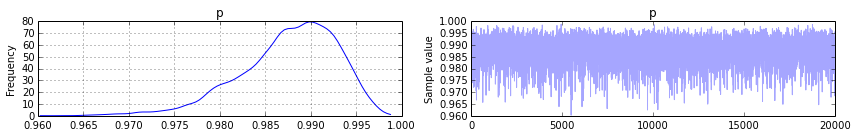

In [9]:
_ = pm.traceplot(trace, ['p'])

In [25]:
fo = open("1.txt", "wb")
pm.summary(trace,['p'],to_file='1.txt')
# pm.summary(trace,['p'])?
# pm.hpd(trace['p'])
fo.close()

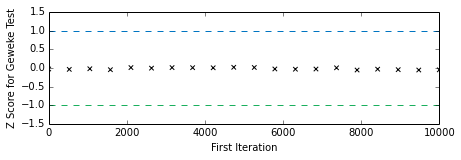

In [47]:
score = pm.geweke(trace.get_values('p'))
figure = plt.figure(figsize=(7,2))
ax = plt.subplot()
_ = ax.scatter(score[:,0],score[:,1],c='black',marker='x')
x_min = min(score[:,0])
x_max = max(score[:,0])            
_ = ax.hlines(y =[-1],xmin=x_min,xmax=x_max,colors='#1aaf5d',linestyles='dashed',linewidths=1)
_ = ax.hlines(y =[1],xmin=x_min,xmax=x_max,colors='#0075c2',linestyles='dashed',linewidths=1)
_ = ax.set_xlim([x_min,x_max])     
_ = ax.set_xlabel('First Iteration')
_ = ax.set_ylabel('Z Score for Geweke Test')
plt.show()

In [49]:
pm.geweke?

array([[<matplotlib.axes.AxesSubplot object at 0x7fda1ba8db10>]], dtype=object)

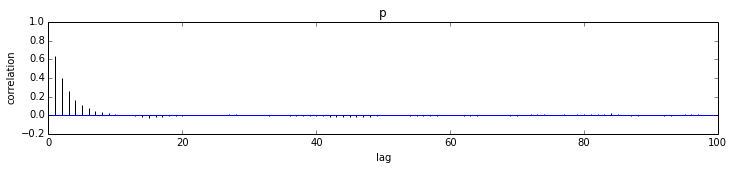

In [48]:
pm.autocorrplot(trace,['p'])